In [28]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms

dataset_storage_directory = './mnist_dataset'
image_resolution = (28, 28)

mnist_dataset = datasets.MNIST(
    root=dataset_storage_directory,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_resolution),
        transforms.ToTensor()
    ]),
    download=True
)
from torch.utils.data import DataLoader

batch_size = 64
indices_of_digit_1 = [i for i, label in enumerate(mnist_dataset.targets) if label == 1]

# Create a subset of the dataset for digit '1' only
#mnist_dataset = Subset(mnist_dataset, indices_of_digit_1)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [29]:
import torch.nn as nn
import torch
class Generator(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Generator, self).__init__()
    self.input_layer = nn.Linear(input_dim, 256)
    self.batch_norm1 = nn.BatchNorm1d(256)
    self.layer_norm1 = nn.LayerNorm(256)
    self.relu1 = nn.LeakyReLU()
    self.hidden_layer_1 = nn.Linear(256, 256)
    self.batch_norm2 = nn.BatchNorm1d(256)
    self.layer_norm2 = nn.LayerNorm(256)
    self.relu2 = nn.LeakyReLU()
    self.hidden_layer_2 = nn.Linear(256, 512)
    self.batch_norm3 = nn.BatchNorm1d(512)
    self.layer_norm3 = nn.LayerNorm(512)
    self.relu3 = nn.LeakyReLU()
    self.hidden_layer_3 = nn.Linear(512, 1024)
    self.batch_norm4 = nn.BatchNorm1d(1024)
    self.layer_norm4 = nn.LayerNorm(1024)
    self.relu4 = nn.LeakyReLU()
    self.hidden_layer_4 = nn.Linear(1024, 2048)
    self.batch_norm5 = nn.BatchNorm1d(2048)
    self.layer_norm5 = nn.LayerNorm(2048)
    self.relu5 = nn.LeakyReLU()
    self.hidden_layer_5 = nn.Linear(2048, 1024)
    self.batch_norm6 = nn.BatchNorm1d(1024)
    self.layer_norm6 = nn.LayerNorm(1024)
    self.relu6 = nn.LeakyReLU()
    self.hidden_layer_6 = nn.Linear(1024, output_dim)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x, apply_sigmoid=False):
    x = self.input_layer(x)
    x = self.batch_norm1(x)
    #x = self.layer_norm1(x)
    x = self.relu1(x)
    x = self.hidden_layer_1(x)
    x = self.batch_norm2(x)
    #x = self.layer_norm2(x)
    x = self.relu2(x)
    x = self.hidden_layer_2(x)
    x = self.batch_norm3(x)
    #x = self.layer_norm3(x)
    x = self.relu3(x)
    x = self.hidden_layer_3(x)
    x = self.batch_norm4(x)
    #x = self.layer_norm4(x)
    x = self.relu4(x)
    x = self.hidden_layer_4(x)
    x = self.batch_norm5(x)
    #x = self.layer_norm5(x)
    x = self.relu5(x)
    x = self.hidden_layer_5(x)
    x = self.batch_norm6(x)
    #x = self.layer_norm6(x)
    x = self.relu6(x)
    x = self.hidden_layer_6(x)
    if apply_sigmoid:
      x = self.sigmoid(x)
    return x
class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim=1):
    super(Discriminator, self).__init__()
    self.input_layer = nn.Linear(input_dim, 256)
    self.relu1 = nn.ReLU()
    self.relu1 = nn.LeakyReLU()
    self.hidden_layer_1 = nn.Linear(256, 512)
    self.relu2 = nn.ReLU()
    self.relu2 = nn.LeakyReLU()
    self.hidden_layer_2 = nn.Linear(512, 512)
    # # self.batch_norm = nn.BatchNorm1d(512)
    self.dropout = nn.Dropout(p=0.5)
    self.relu3 = nn.ReLU()
    self.relu3 = nn.LeakyReLU()
    self.hidden_layer_3 = nn.Linear(512, output_dim)
    # self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    x = self.input_layer(x)
    x = self.relu1(x)
    x = self.hidden_layer_1(x)
    # x = self.batch_norm(x)
    x = self.relu2(x)
    x = self.dropout(x)
    x = self.hidden_layer_2(x)
    x = self.relu3(x)
    x = self.hidden_layer_3(x)
    return x

In [35]:
# def fake_loss(fake_image_discrimination):
#     gan_score = torch.log(1 - fake_image_discrimination)
#     gan_score = -1 * gan_score
#     return gan_score.mean()

# def real_loss(real_image_discrimination):
#     gan_score = torch.log(fake_image_discrimination)
#     gan_score = -1 * gan_score
#     return gan_score.mean()
def discrim_loss_func(real_image_discrimination, fake_image_discrimination):
    gan_score = torch.log(fake_image_discrimination) + torch.log(1 - real_image_discrimination)
    return gan_score.mean()

def discriminator_loss_func(real_image_discrimination, fake_image_discrimination):
    #print(real_image_discrimination, fake_image_discrimination)
    #real_targets = torch.ones_like(real_image_discrimination)
    real_targets = torch.full_like(real_image_discrimination, 0.9)
    #fake_targets = torch.zeros_like(fake_image_discrimination
    fake_targets = torch.zeros_like(fake_image_discrimination)
    # real_loss = torch.nn.functional.binary_cross_entropy(real_image_discrimination, real_targets)
    # fake_loss = torch.nn.functional.binary_cross_entropy(fake_image_discrimination, fake_targets)
    real_loss = torch.nn.functional.binary_cross_entropy_with_logits(real_image_discrimination, real_targets)
    fake_loss = torch.nn.functional.binary_cross_entropy_with_logits(fake_image_discrimination, fake_targets)

    return real_loss + fake_loss
def discriminator_loss_wasserstein(real_image_discrimination, fake_image_discrimination):
    return -(real_image_discrimination.mean() - fake_image_discrimination.mean())
def generator_loss_func(fake_image_discrimination):
    gan_score = torch.log(fake_image_discrimination)
    gan_score = -1 * gan_score
    return gan_score.mean()
def generator_loss_func(fake_image_discrimination):
    #return torch.nn.functional.binary_cross_entropy(fake_image_discrimination, torch.ones_like(fake_image_discrimination))
    #return torch.nn.functional.binary_cross_entropy_with_logits(fake_image_discrimination, torch.ones_like(fake_image_discrimination))
    return torch.nn.functional.binary_cross_entropy_with_logits(fake_image_discrimination, torch.full_like(fake_image_discrimination, 1))
def generator_loss_wasserstein(fake_image_discrimination):
    return -fake_image_discrimination.mean()
def discriminator_loss_wasserstein_with_gradient_penalty(real_image_discrimination, fake_image_discrimination, fake_image_data):
    return (real_image_discrimination.mean() - fake_image_discrimination.mean()) + GAMMA * torch.square(torch.norm(fake_image_discrimination.grad) - 1)
def grad_penal(discriminator, real_images, fake_images):
    eps = torch.rand(batch_size, 784).to(device)
    fake_data = eps * real_images + (1 - eps) * fake_images
    fake_data.requires_grad_(True)
    fake_data_discrimination = discriminator(fake_data)
    fake_data_grads = torch.ones_like(fake_data_discrimination)
    grads = torch.autograd.grad(outputs=fake_data_discrimination, inputs=fake_data, grad_outputs=torch.ones_like(fake_data_grads), create_graph=True,retain_graph=True,only_inputs=True)[0]
    gradient_norm = grads.norm(2)
    return torch.square(gradient_norm - 1).mean()
EPOCHS = 30
GAMMA = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = Generator(100, 784).to(device)
discriminator = Discriminator(784, 1).to(device)
def weights_init(module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, 0.0, 0.02)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)
from tqdm.notebook import tqdm
#optimizer = torch.optim.Adam(list(generator.parameters()) + list(discriminator.parameters()), lr=0.03)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
for i in range(0, EPOCHS):
  for real_images_batch, _ in tqdm(dataloader, desc=f"Epoch {i+1}"):
    real_images_batch = real_images_batch.to(device)
    real_images_batch = real_images_batch.float()
    real_images_batch = torch.flatten(real_images_batch, start_dim=1)
    for _ in range(5):
        fake_images_noise_batch = torch.randn(batch_size, 100).to(device)
        generated_fake_images = generator(fake_images_noise_batch).detach()
        # real_image_discrimination = discriminator(real_images_batch)
        # fake_image_discrimination = discriminator(generated_fake_images)
        #epsilon = torch.rand(batch_size, 1).to(device)
        #print(epsilon.shape, real_images_batch.shape, generated_fake_images.shape)
        #fake_image_data = (1 - epsilon) * real_images_batch + epsilon * generated_fake_images
        #fake_image_data.requires_grad = True
        fake_image_discrimination = discriminator(generated_fake_images)
        real_image_discrimination = discriminator(real_images_batch)
        grad_penalty = grad_penal(discriminator, real_images_batch, generated_fake_images)
        discrim_loss = -real_image_discrimination.mean() + fake_image_discrimination.mean() + GAMMA * grad_penalty
        #loss = discriminator_loss_wasserstein_with_gradient_penalty(real_image_discrimination, fake_image_discrimination, fake_image_data)
        #discrim_loss = discriminator_loss_wasserstein(real_image_discrimination, fake_image_discrimination)
        # fake_loss = fake_loss(fake_image_discrimination)
        # real_loss = real_loss(real_image_discrimination)


        #loss = discrim_loss_func(real_image_discrimination, fake_image_discrimination)
        #loss = gan_loss_function(fake_image_discrimination, real_image_discrimination)
        #optimizer.zero_grad()
        disc_optimizer.zero_grad()
        discrim_loss.backward()
        disc_optimizer.step()

    for _ in range(1):
        fake_images_noise_batch = torch.randn(batch_size, 100).to(device)
        generated_fake_images = generator(fake_images_noise_batch)
        fake_image_discrimination = discriminator(generated_fake_images)
        generator_loss = generator_loss_wasserstein(fake_image_discrimination)
        gen_optimizer.zero_grad()
        generator_loss.backward()
        # fake_loss.backward()
        # real_loss.backward()
        print(generator_loss, discrim_loss)
        gen_optimizer.step()
        #optimizer.step()

Epoch 1:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.0074, grad_fn=<NegBackward0>) tensor(5.4664, grad_fn=<AddBackward0>)
tensor(-0.0302, grad_fn=<NegBackward0>) tensor(1.5640, grad_fn=<AddBackward0>)
tensor(-0.1625, grad_fn=<NegBackward0>) tensor(0.4080, grad_fn=<AddBackward0>)
tensor(-0.1890, grad_fn=<NegBackward0>) tensor(0.1673, grad_fn=<AddBackward0>)
tensor(-0.1759, grad_fn=<NegBackward0>) tensor(0.2926, grad_fn=<AddBackward0>)
tensor(-0.2346, grad_fn=<NegBackward0>) tensor(0.0531, grad_fn=<AddBackward0>)
tensor(-0.2374, grad_fn=<NegBackward0>) tensor(0.1341, grad_fn=<AddBackward0>)
tensor(-0.1857, grad_fn=<NegBackward0>) tensor(-0.0899, grad_fn=<AddBackward0>)
tensor(-0.1037, grad_fn=<NegBackward0>) tensor(-0.2002, grad_fn=<AddBackward0>)
tensor(0.0143, grad_fn=<NegBackward0>) tensor(-0.2976, grad_fn=<AddBackward0>)
tensor(0.2335, grad_fn=<NegBackward0>) tensor(-0.5004, grad_fn=<AddBackward0>)
tensor(0.5075, grad_fn=<NegBackward0>) tensor(-0.4794, grad_fn=<AddBackward0>)
tensor(0.7686, grad_fn=<NegBackward0>) tensor(-0.86

Epoch 2:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.1063, grad_fn=<NegBackward0>) tensor(-0.2655, grad_fn=<AddBackward0>)
tensor(0.2466, grad_fn=<NegBackward0>) tensor(-0.2404, grad_fn=<AddBackward0>)
tensor(0.3626, grad_fn=<NegBackward0>) tensor(-0.2697, grad_fn=<AddBackward0>)
tensor(0.2598, grad_fn=<NegBackward0>) tensor(-0.2181, grad_fn=<AddBackward0>)
tensor(0.1323, grad_fn=<NegBackward0>) tensor(-0.2683, grad_fn=<AddBackward0>)
tensor(0.1157, grad_fn=<NegBackward0>) tensor(-0.2772, grad_fn=<AddBackward0>)
tensor(0.1096, grad_fn=<NegBackward0>) tensor(-0.2916, grad_fn=<AddBackward0>)
tensor(0.1477, grad_fn=<NegBackward0>) tensor(-0.3130, grad_fn=<AddBackward0>)
tensor(0.2478, grad_fn=<NegBackward0>) tensor(-0.3088, grad_fn=<AddBackward0>)
tensor(0.3287, grad_fn=<NegBackward0>) tensor(-0.3011, grad_fn=<AddBackward0>)
tensor(0.3098, grad_fn=<NegBackward0>) tensor(-0.2719, grad_fn=<AddBackward0>)
tensor(0.2705, grad_fn=<NegBackward0>) tensor(-0.2811, grad_fn=<AddBackward0>)
tensor(0.2281, grad_fn=<NegBackward0>) tensor(-0.252

Epoch 3:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.0427, grad_fn=<NegBackward0>) tensor(-0.3101, grad_fn=<AddBackward0>)
tensor(0.1041, grad_fn=<NegBackward0>) tensor(-0.2999, grad_fn=<AddBackward0>)
tensor(0.1486, grad_fn=<NegBackward0>) tensor(-0.3108, grad_fn=<AddBackward0>)
tensor(0.1496, grad_fn=<NegBackward0>) tensor(-0.3143, grad_fn=<AddBackward0>)
tensor(0.2253, grad_fn=<NegBackward0>) tensor(-0.3165, grad_fn=<AddBackward0>)
tensor(0.2766, grad_fn=<NegBackward0>) tensor(-0.3069, grad_fn=<AddBackward0>)
tensor(0.3660, grad_fn=<NegBackward0>) tensor(-0.2877, grad_fn=<AddBackward0>)
tensor(0.4726, grad_fn=<NegBackward0>) tensor(-0.3720, grad_fn=<AddBackward0>)
tensor(0.5257, grad_fn=<NegBackward0>) tensor(-0.3527, grad_fn=<AddBackward0>)
tensor(0.6337, grad_fn=<NegBackward0>) tensor(-0.3316, grad_fn=<AddBackward0>)
tensor(0.6247, grad_fn=<NegBackward0>) tensor(-0.3268, grad_fn=<AddBackward0>)
tensor(0.5208, grad_fn=<NegBackward0>) tensor(-0.3108, grad_fn=<AddBackward0>)
tensor(0.4213, grad_fn=<NegBackward0>) tensor(-0.336

Epoch 4:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.4792, grad_fn=<NegBackward0>) tensor(-0.3449, grad_fn=<AddBackward0>)
tensor(0.6285, grad_fn=<NegBackward0>) tensor(-0.2042, grad_fn=<AddBackward0>)
tensor(1.2104, grad_fn=<NegBackward0>) tensor(-0.1985, grad_fn=<AddBackward0>)
tensor(0.8459, grad_fn=<NegBackward0>) tensor(-0.2100, grad_fn=<AddBackward0>)
tensor(0.6432, grad_fn=<NegBackward0>) tensor(-0.1637, grad_fn=<AddBackward0>)
tensor(0.4699, grad_fn=<NegBackward0>) tensor(-0.2243, grad_fn=<AddBackward0>)
tensor(0.2184, grad_fn=<NegBackward0>) tensor(-0.2674, grad_fn=<AddBackward0>)
tensor(0.1020, grad_fn=<NegBackward0>) tensor(-0.2464, grad_fn=<AddBackward0>)
tensor(0.0353, grad_fn=<NegBackward0>) tensor(-0.1791, grad_fn=<AddBackward0>)
tensor(0.0645, grad_fn=<NegBackward0>) tensor(-0.2310, grad_fn=<AddBackward0>)
tensor(0.0844, grad_fn=<NegBackward0>) tensor(-0.2221, grad_fn=<AddBackward0>)
tensor(0.0403, grad_fn=<NegBackward0>) tensor(-0.2378, grad_fn=<AddBackward0>)
tensor(-0.0483, grad_fn=<NegBackward0>) tensor(-0.20

Epoch 5:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(-0.0816, grad_fn=<NegBackward0>) tensor(-0.2383, grad_fn=<AddBackward0>)
tensor(-0.0518, grad_fn=<NegBackward0>) tensor(-0.2207, grad_fn=<AddBackward0>)
tensor(0.0258, grad_fn=<NegBackward0>) tensor(-0.1680, grad_fn=<AddBackward0>)
tensor(-0.1168, grad_fn=<NegBackward0>) tensor(-0.2256, grad_fn=<AddBackward0>)
tensor(-0.2296, grad_fn=<NegBackward0>) tensor(-0.2458, grad_fn=<AddBackward0>)
tensor(-0.2472, grad_fn=<NegBackward0>) tensor(-0.2469, grad_fn=<AddBackward0>)
tensor(-0.2663, grad_fn=<NegBackward0>) tensor(-0.2181, grad_fn=<AddBackward0>)
tensor(-0.0874, grad_fn=<NegBackward0>) tensor(-0.2459, grad_fn=<AddBackward0>)
tensor(-0.0102, grad_fn=<NegBackward0>) tensor(-0.2336, grad_fn=<AddBackward0>)
tensor(0.1889, grad_fn=<NegBackward0>) tensor(-0.2065, grad_fn=<AddBackward0>)
tensor(0.2444, grad_fn=<NegBackward0>) tensor(-0.2424, grad_fn=<AddBackward0>)
tensor(0.2935, grad_fn=<NegBackward0>) tensor(-0.2301, grad_fn=<AddBackward0>)
tensor(0.2985, grad_fn=<NegBackward0>) tenso

Epoch 6:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.0591, grad_fn=<NegBackward0>) tensor(-0.2131, grad_fn=<AddBackward0>)
tensor(0.0308, grad_fn=<NegBackward0>) tensor(-0.1757, grad_fn=<AddBackward0>)
tensor(0.1132, grad_fn=<NegBackward0>) tensor(-0.1977, grad_fn=<AddBackward0>)
tensor(0.1905, grad_fn=<NegBackward0>) tensor(-0.1805, grad_fn=<AddBackward0>)
tensor(0.2513, grad_fn=<NegBackward0>) tensor(-0.2021, grad_fn=<AddBackward0>)
tensor(0.2472, grad_fn=<NegBackward0>) tensor(-0.2221, grad_fn=<AddBackward0>)
tensor(0.2625, grad_fn=<NegBackward0>) tensor(-0.1719, grad_fn=<AddBackward0>)
tensor(0.1465, grad_fn=<NegBackward0>) tensor(-0.2217, grad_fn=<AddBackward0>)
tensor(0.1765, grad_fn=<NegBackward0>) tensor(-0.2687, grad_fn=<AddBackward0>)
tensor(0.2459, grad_fn=<NegBackward0>) tensor(-0.2407, grad_fn=<AddBackward0>)
tensor(0.3835, grad_fn=<NegBackward0>) tensor(-0.1857, grad_fn=<AddBackward0>)
tensor(0.4524, grad_fn=<NegBackward0>) tensor(-0.2482, grad_fn=<AddBackward0>)
tensor(0.2763, grad_fn=<NegBackward0>) tensor(-0.190

Epoch 7:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.2317, grad_fn=<NegBackward0>) tensor(-0.1674, grad_fn=<AddBackward0>)
tensor(0.0894, grad_fn=<NegBackward0>) tensor(-0.2006, grad_fn=<AddBackward0>)
tensor(0.0399, grad_fn=<NegBackward0>) tensor(-0.2251, grad_fn=<AddBackward0>)
tensor(-0.0375, grad_fn=<NegBackward0>) tensor(-0.2248, grad_fn=<AddBackward0>)
tensor(-0.0737, grad_fn=<NegBackward0>) tensor(-0.2292, grad_fn=<AddBackward0>)
tensor(-0.1343, grad_fn=<NegBackward0>) tensor(-0.1867, grad_fn=<AddBackward0>)
tensor(-0.1026, grad_fn=<NegBackward0>) tensor(-0.2607, grad_fn=<AddBackward0>)
tensor(-0.1413, grad_fn=<NegBackward0>) tensor(-0.2057, grad_fn=<AddBackward0>)
tensor(-0.1609, grad_fn=<NegBackward0>) tensor(-0.2301, grad_fn=<AddBackward0>)
tensor(-0.1763, grad_fn=<NegBackward0>) tensor(-0.1551, grad_fn=<AddBackward0>)
tensor(-0.0677, grad_fn=<NegBackward0>) tensor(-0.2358, grad_fn=<AddBackward0>)
tensor(-0.0153, grad_fn=<NegBackward0>) tensor(-0.2020, grad_fn=<AddBackward0>)
tensor(-0.0211, grad_fn=<NegBackward0>) ten

Epoch 8:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.7021, grad_fn=<NegBackward0>) tensor(-0.2230, grad_fn=<AddBackward0>)
tensor(0.8730, grad_fn=<NegBackward0>) tensor(-0.2348, grad_fn=<AddBackward0>)
tensor(0.8703, grad_fn=<NegBackward0>) tensor(-0.2289, grad_fn=<AddBackward0>)
tensor(0.7662, grad_fn=<NegBackward0>) tensor(-0.0865, grad_fn=<AddBackward0>)
tensor(0.5567, grad_fn=<NegBackward0>) tensor(-0.1236, grad_fn=<AddBackward0>)
tensor(0.4802, grad_fn=<NegBackward0>) tensor(-0.1333, grad_fn=<AddBackward0>)
tensor(0.2893, grad_fn=<NegBackward0>) tensor(-0.1556, grad_fn=<AddBackward0>)
tensor(0.1677, grad_fn=<NegBackward0>) tensor(-0.1603, grad_fn=<AddBackward0>)
tensor(0.0314, grad_fn=<NegBackward0>) tensor(-0.2089, grad_fn=<AddBackward0>)
tensor(0.0656, grad_fn=<NegBackward0>) tensor(-0.1940, grad_fn=<AddBackward0>)
tensor(0.1584, grad_fn=<NegBackward0>) tensor(-0.1743, grad_fn=<AddBackward0>)
tensor(0.2494, grad_fn=<NegBackward0>) tensor(-0.2061, grad_fn=<AddBackward0>)
tensor(0.2205, grad_fn=<NegBackward0>) tensor(-0.206

Epoch 9:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(-0.1919, grad_fn=<NegBackward0>) tensor(-0.2462, grad_fn=<AddBackward0>)
tensor(-0.1251, grad_fn=<NegBackward0>) tensor(-0.1677, grad_fn=<AddBackward0>)
tensor(-0.1271, grad_fn=<NegBackward0>) tensor(-0.1662, grad_fn=<AddBackward0>)
tensor(-0.0523, grad_fn=<NegBackward0>) tensor(-0.1280, grad_fn=<AddBackward0>)
tensor(-0.0244, grad_fn=<NegBackward0>) tensor(-0.2219, grad_fn=<AddBackward0>)
tensor(0.0223, grad_fn=<NegBackward0>) tensor(-0.1926, grad_fn=<AddBackward0>)
tensor(0.0305, grad_fn=<NegBackward0>) tensor(-0.2086, grad_fn=<AddBackward0>)
tensor(0.0550, grad_fn=<NegBackward0>) tensor(-0.1781, grad_fn=<AddBackward0>)
tensor(0.0440, grad_fn=<NegBackward0>) tensor(-0.1406, grad_fn=<AddBackward0>)
tensor(-0.0384, grad_fn=<NegBackward0>) tensor(-0.1931, grad_fn=<AddBackward0>)
tensor(0.0680, grad_fn=<NegBackward0>) tensor(-0.1920, grad_fn=<AddBackward0>)
tensor(0.2034, grad_fn=<NegBackward0>) tensor(-0.1516, grad_fn=<AddBackward0>)
tensor(0.4140, grad_fn=<NegBackward0>) tensor(

Epoch 10:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(-0.1891, grad_fn=<NegBackward0>) tensor(-0.1457, grad_fn=<AddBackward0>)
tensor(-0.3802, grad_fn=<NegBackward0>) tensor(-0.1008, grad_fn=<AddBackward0>)
tensor(-0.2256, grad_fn=<NegBackward0>) tensor(-0.1520, grad_fn=<AddBackward0>)
tensor(-0.0367, grad_fn=<NegBackward0>) tensor(-0.1847, grad_fn=<AddBackward0>)
tensor(0.1192, grad_fn=<NegBackward0>) tensor(-0.1714, grad_fn=<AddBackward0>)
tensor(0.1218, grad_fn=<NegBackward0>) tensor(-0.1649, grad_fn=<AddBackward0>)
tensor(0.1628, grad_fn=<NegBackward0>) tensor(-0.1817, grad_fn=<AddBackward0>)
tensor(0.2004, grad_fn=<NegBackward0>) tensor(-0.1822, grad_fn=<AddBackward0>)
tensor(0.3858, grad_fn=<NegBackward0>) tensor(-0.1819, grad_fn=<AddBackward0>)
tensor(0.6742, grad_fn=<NegBackward0>) tensor(-0.2632, grad_fn=<AddBackward0>)
tensor(0.8046, grad_fn=<NegBackward0>) tensor(-0.2103, grad_fn=<AddBackward0>)
tensor(0.7775, grad_fn=<NegBackward0>) tensor(-0.1884, grad_fn=<AddBackward0>)
tensor(0.9063, grad_fn=<NegBackward0>) tensor(-0

Epoch 11:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.9373, grad_fn=<NegBackward0>) tensor(-0.1497, grad_fn=<AddBackward0>)
tensor(1.0947, grad_fn=<NegBackward0>) tensor(-0.1797, grad_fn=<AddBackward0>)
tensor(1.0588, grad_fn=<NegBackward0>) tensor(-0.1474, grad_fn=<AddBackward0>)
tensor(0.9671, grad_fn=<NegBackward0>) tensor(-0.2098, grad_fn=<AddBackward0>)
tensor(0.9012, grad_fn=<NegBackward0>) tensor(-0.2980, grad_fn=<AddBackward0>)
tensor(0.8176, grad_fn=<NegBackward0>) tensor(-0.1118, grad_fn=<AddBackward0>)
tensor(0.7527, grad_fn=<NegBackward0>) tensor(-0.1561, grad_fn=<AddBackward0>)
tensor(0.6410, grad_fn=<NegBackward0>) tensor(-0.0910, grad_fn=<AddBackward0>)
tensor(0.6520, grad_fn=<NegBackward0>) tensor(-0.1403, grad_fn=<AddBackward0>)
tensor(0.5697, grad_fn=<NegBackward0>) tensor(-0.0878, grad_fn=<AddBackward0>)
tensor(0.5791, grad_fn=<NegBackward0>) tensor(-0.1492, grad_fn=<AddBackward0>)
tensor(0.5245, grad_fn=<NegBackward0>) tensor(-0.1712, grad_fn=<AddBackward0>)
tensor(0.5665, grad_fn=<NegBackward0>) tensor(-0.112

Epoch 12:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.4678, grad_fn=<NegBackward0>) tensor(-0.1171, grad_fn=<AddBackward0>)
tensor(0.5250, grad_fn=<NegBackward0>) tensor(-0.1953, grad_fn=<AddBackward0>)
tensor(0.6090, grad_fn=<NegBackward0>) tensor(-0.1617, grad_fn=<AddBackward0>)
tensor(0.5627, grad_fn=<NegBackward0>) tensor(-0.1669, grad_fn=<AddBackward0>)
tensor(0.4634, grad_fn=<NegBackward0>) tensor(-0.1552, grad_fn=<AddBackward0>)
tensor(0.4235, grad_fn=<NegBackward0>) tensor(-0.1139, grad_fn=<AddBackward0>)
tensor(0.4698, grad_fn=<NegBackward0>) tensor(-0.1528, grad_fn=<AddBackward0>)
tensor(0.4286, grad_fn=<NegBackward0>) tensor(-0.1534, grad_fn=<AddBackward0>)
tensor(0.3902, grad_fn=<NegBackward0>) tensor(-0.1372, grad_fn=<AddBackward0>)
tensor(0.3152, grad_fn=<NegBackward0>) tensor(-0.1495, grad_fn=<AddBackward0>)
tensor(0.2299, grad_fn=<NegBackward0>) tensor(-0.1933, grad_fn=<AddBackward0>)
tensor(0.0948, grad_fn=<NegBackward0>) tensor(-0.1734, grad_fn=<AddBackward0>)
tensor(-0.0111, grad_fn=<NegBackward0>) tensor(-0.16

Epoch 13:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.1874, grad_fn=<NegBackward0>) tensor(-0.1439, grad_fn=<AddBackward0>)
tensor(0.2161, grad_fn=<NegBackward0>) tensor(-0.1366, grad_fn=<AddBackward0>)
tensor(0.2342, grad_fn=<NegBackward0>) tensor(-0.1278, grad_fn=<AddBackward0>)
tensor(0.3170, grad_fn=<NegBackward0>) tensor(-0.1500, grad_fn=<AddBackward0>)
tensor(0.2768, grad_fn=<NegBackward0>) tensor(-0.1324, grad_fn=<AddBackward0>)
tensor(0.2330, grad_fn=<NegBackward0>) tensor(-0.1059, grad_fn=<AddBackward0>)
tensor(0.3421, grad_fn=<NegBackward0>) tensor(-0.1467, grad_fn=<AddBackward0>)
tensor(0.3892, grad_fn=<NegBackward0>) tensor(-0.1775, grad_fn=<AddBackward0>)
tensor(0.4282, grad_fn=<NegBackward0>) tensor(-0.1348, grad_fn=<AddBackward0>)
tensor(0.4039, grad_fn=<NegBackward0>) tensor(-0.1561, grad_fn=<AddBackward0>)
tensor(0.4070, grad_fn=<NegBackward0>) tensor(-0.1257, grad_fn=<AddBackward0>)
tensor(0.4466, grad_fn=<NegBackward0>) tensor(-0.1245, grad_fn=<AddBackward0>)
tensor(0.4298, grad_fn=<NegBackward0>) tensor(-0.162

Epoch 14:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.3990, grad_fn=<NegBackward0>) tensor(-0.1540, grad_fn=<AddBackward0>)
tensor(0.3982, grad_fn=<NegBackward0>) tensor(-0.1463, grad_fn=<AddBackward0>)
tensor(0.3791, grad_fn=<NegBackward0>) tensor(-0.1345, grad_fn=<AddBackward0>)
tensor(0.4162, grad_fn=<NegBackward0>) tensor(-0.1893, grad_fn=<AddBackward0>)
tensor(0.4075, grad_fn=<NegBackward0>) tensor(-0.1253, grad_fn=<AddBackward0>)
tensor(0.4299, grad_fn=<NegBackward0>) tensor(-0.1517, grad_fn=<AddBackward0>)
tensor(0.4751, grad_fn=<NegBackward0>) tensor(-0.0951, grad_fn=<AddBackward0>)
tensor(0.4745, grad_fn=<NegBackward0>) tensor(-0.0729, grad_fn=<AddBackward0>)
tensor(0.4338, grad_fn=<NegBackward0>) tensor(-0.1359, grad_fn=<AddBackward0>)
tensor(0.3915, grad_fn=<NegBackward0>) tensor(-0.1240, grad_fn=<AddBackward0>)
tensor(0.3269, grad_fn=<NegBackward0>) tensor(-0.1307, grad_fn=<AddBackward0>)
tensor(0.1683, grad_fn=<NegBackward0>) tensor(-0.1190, grad_fn=<AddBackward0>)
tensor(0.1427, grad_fn=<NegBackward0>) tensor(-0.131

Epoch 15:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.6078, grad_fn=<NegBackward0>) tensor(-0.1471, grad_fn=<AddBackward0>)
tensor(0.5172, grad_fn=<NegBackward0>) tensor(-0.1454, grad_fn=<AddBackward0>)
tensor(0.3969, grad_fn=<NegBackward0>) tensor(-0.1005, grad_fn=<AddBackward0>)
tensor(0.3749, grad_fn=<NegBackward0>) tensor(-0.1454, grad_fn=<AddBackward0>)
tensor(0.3519, grad_fn=<NegBackward0>) tensor(-0.1337, grad_fn=<AddBackward0>)
tensor(0.3297, grad_fn=<NegBackward0>) tensor(-0.1424, grad_fn=<AddBackward0>)
tensor(0.4326, grad_fn=<NegBackward0>) tensor(-0.1345, grad_fn=<AddBackward0>)
tensor(0.4455, grad_fn=<NegBackward0>) tensor(-0.1526, grad_fn=<AddBackward0>)
tensor(0.4639, grad_fn=<NegBackward0>) tensor(-0.1533, grad_fn=<AddBackward0>)
tensor(0.4482, grad_fn=<NegBackward0>) tensor(-0.1191, grad_fn=<AddBackward0>)
tensor(0.4420, grad_fn=<NegBackward0>) tensor(-0.1448, grad_fn=<AddBackward0>)
tensor(0.4472, grad_fn=<NegBackward0>) tensor(-0.1387, grad_fn=<AddBackward0>)
tensor(0.4159, grad_fn=<NegBackward0>) tensor(-0.157

Epoch 16:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(-0.1292, grad_fn=<NegBackward0>) tensor(-0.1499, grad_fn=<AddBackward0>)
tensor(-0.1011, grad_fn=<NegBackward0>) tensor(-0.1261, grad_fn=<AddBackward0>)
tensor(0.1179, grad_fn=<NegBackward0>) tensor(-0.1194, grad_fn=<AddBackward0>)
tensor(0.2770, grad_fn=<NegBackward0>) tensor(-0.1035, grad_fn=<AddBackward0>)
tensor(0.4828, grad_fn=<NegBackward0>) tensor(-0.1493, grad_fn=<AddBackward0>)
tensor(0.6095, grad_fn=<NegBackward0>) tensor(-0.1156, grad_fn=<AddBackward0>)
tensor(0.8349, grad_fn=<NegBackward0>) tensor(-0.1169, grad_fn=<AddBackward0>)
tensor(1.0774, grad_fn=<NegBackward0>) tensor(-0.0986, grad_fn=<AddBackward0>)
tensor(1.0248, grad_fn=<NegBackward0>) tensor(-0.2113, grad_fn=<AddBackward0>)
tensor(1.3216, grad_fn=<NegBackward0>) tensor(-0.1799, grad_fn=<AddBackward0>)
tensor(1.0960, grad_fn=<NegBackward0>) tensor(-0.1009, grad_fn=<AddBackward0>)
tensor(1.1430, grad_fn=<NegBackward0>) tensor(-0.1133, grad_fn=<AddBackward0>)
tensor(1.1752, grad_fn=<NegBackward0>) tensor(-0.2

Epoch 17:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.5604, grad_fn=<NegBackward0>) tensor(-0.1736, grad_fn=<AddBackward0>)
tensor(0.6367, grad_fn=<NegBackward0>) tensor(-0.0675, grad_fn=<AddBackward0>)
tensor(0.6500, grad_fn=<NegBackward0>) tensor(-0.1342, grad_fn=<AddBackward0>)
tensor(0.7137, grad_fn=<NegBackward0>) tensor(-0.1423, grad_fn=<AddBackward0>)
tensor(0.8072, grad_fn=<NegBackward0>) tensor(-0.1621, grad_fn=<AddBackward0>)
tensor(1.0305, grad_fn=<NegBackward0>) tensor(-0.2454, grad_fn=<AddBackward0>)
tensor(1.0372, grad_fn=<NegBackward0>) tensor(-0.1446, grad_fn=<AddBackward0>)
tensor(0.9309, grad_fn=<NegBackward0>) tensor(-0.0813, grad_fn=<AddBackward0>)
tensor(0.7967, grad_fn=<NegBackward0>) tensor(-0.1766, grad_fn=<AddBackward0>)
tensor(0.6796, grad_fn=<NegBackward0>) tensor(-0.0377, grad_fn=<AddBackward0>)
tensor(0.5787, grad_fn=<NegBackward0>) tensor(-0.1063, grad_fn=<AddBackward0>)
tensor(0.5134, grad_fn=<NegBackward0>) tensor(-0.1443, grad_fn=<AddBackward0>)
tensor(0.5017, grad_fn=<NegBackward0>) tensor(-0.164

Epoch 18:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.6742, grad_fn=<NegBackward0>) tensor(-0.0481, grad_fn=<AddBackward0>)
tensor(0.6057, grad_fn=<NegBackward0>) tensor(-0.0945, grad_fn=<AddBackward0>)
tensor(0.4904, grad_fn=<NegBackward0>) tensor(-0.1334, grad_fn=<AddBackward0>)
tensor(0.4512, grad_fn=<NegBackward0>) tensor(-0.1060, grad_fn=<AddBackward0>)
tensor(0.4756, grad_fn=<NegBackward0>) tensor(-0.1257, grad_fn=<AddBackward0>)
tensor(0.4646, grad_fn=<NegBackward0>) tensor(-0.1283, grad_fn=<AddBackward0>)
tensor(0.5636, grad_fn=<NegBackward0>) tensor(-0.0809, grad_fn=<AddBackward0>)
tensor(0.6173, grad_fn=<NegBackward0>) tensor(-0.1085, grad_fn=<AddBackward0>)
tensor(0.6358, grad_fn=<NegBackward0>) tensor(-0.0830, grad_fn=<AddBackward0>)
tensor(0.6824, grad_fn=<NegBackward0>) tensor(-0.1081, grad_fn=<AddBackward0>)
tensor(0.5006, grad_fn=<NegBackward0>) tensor(-0.1451, grad_fn=<AddBackward0>)
tensor(0.4615, grad_fn=<NegBackward0>) tensor(-0.1406, grad_fn=<AddBackward0>)
tensor(0.5129, grad_fn=<NegBackward0>) tensor(-0.154

Epoch 19:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(1.2476, grad_fn=<NegBackward0>) tensor(-0.0846, grad_fn=<AddBackward0>)
tensor(1.2886, grad_fn=<NegBackward0>) tensor(-0.2451, grad_fn=<AddBackward0>)
tensor(1.1260, grad_fn=<NegBackward0>) tensor(-0.0031, grad_fn=<AddBackward0>)
tensor(1.1511, grad_fn=<NegBackward0>) tensor(-0.1269, grad_fn=<AddBackward0>)
tensor(0.8228, grad_fn=<NegBackward0>) tensor(-0.1223, grad_fn=<AddBackward0>)
tensor(0.6879, grad_fn=<NegBackward0>) tensor(-0.0859, grad_fn=<AddBackward0>)
tensor(0.6719, grad_fn=<NegBackward0>) tensor(-0.1133, grad_fn=<AddBackward0>)
tensor(0.6271, grad_fn=<NegBackward0>) tensor(-0.1047, grad_fn=<AddBackward0>)
tensor(0.6282, grad_fn=<NegBackward0>) tensor(-0.1199, grad_fn=<AddBackward0>)
tensor(0.5870, grad_fn=<NegBackward0>) tensor(-0.1410, grad_fn=<AddBackward0>)
tensor(0.5576, grad_fn=<NegBackward0>) tensor(-0.1273, grad_fn=<AddBackward0>)
tensor(0.5359, grad_fn=<NegBackward0>) tensor(-0.0837, grad_fn=<AddBackward0>)
tensor(0.5823, grad_fn=<NegBackward0>) tensor(-0.102

Epoch 20:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.7944, grad_fn=<NegBackward0>) tensor(-0.0022, grad_fn=<AddBackward0>)
tensor(0.9011, grad_fn=<NegBackward0>) tensor(-0.1311, grad_fn=<AddBackward0>)
tensor(1.0256, grad_fn=<NegBackward0>) tensor(-0.1050, grad_fn=<AddBackward0>)
tensor(0.9879, grad_fn=<NegBackward0>) tensor(-0.1921, grad_fn=<AddBackward0>)
tensor(1.0598, grad_fn=<NegBackward0>) tensor(-0.1084, grad_fn=<AddBackward0>)
tensor(1.2446, grad_fn=<NegBackward0>) tensor(-0.0971, grad_fn=<AddBackward0>)
tensor(1.0674, grad_fn=<NegBackward0>) tensor(0.0139, grad_fn=<AddBackward0>)
tensor(1.0914, grad_fn=<NegBackward0>) tensor(-0.1201, grad_fn=<AddBackward0>)
tensor(0.9744, grad_fn=<NegBackward0>) tensor(-0.1521, grad_fn=<AddBackward0>)
tensor(1.1921, grad_fn=<NegBackward0>) tensor(-0.1600, grad_fn=<AddBackward0>)
tensor(0.8425, grad_fn=<NegBackward0>) tensor(-0.0847, grad_fn=<AddBackward0>)
tensor(0.7971, grad_fn=<NegBackward0>) tensor(-0.0758, grad_fn=<AddBackward0>)
tensor(0.5268, grad_fn=<NegBackward0>) tensor(-0.1338

Epoch 21:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.5218, grad_fn=<NegBackward0>) tensor(-0.1294, grad_fn=<AddBackward0>)
tensor(0.5627, grad_fn=<NegBackward0>) tensor(-0.1298, grad_fn=<AddBackward0>)
tensor(0.6256, grad_fn=<NegBackward0>) tensor(-0.0976, grad_fn=<AddBackward0>)
tensor(0.5808, grad_fn=<NegBackward0>) tensor(-0.1110, grad_fn=<AddBackward0>)
tensor(0.6074, grad_fn=<NegBackward0>) tensor(-0.1053, grad_fn=<AddBackward0>)
tensor(0.6683, grad_fn=<NegBackward0>) tensor(-0.1165, grad_fn=<AddBackward0>)
tensor(0.6728, grad_fn=<NegBackward0>) tensor(-0.0830, grad_fn=<AddBackward0>)
tensor(0.5669, grad_fn=<NegBackward0>) tensor(-0.1487, grad_fn=<AddBackward0>)
tensor(0.3909, grad_fn=<NegBackward0>) tensor(-0.1321, grad_fn=<AddBackward0>)
tensor(0.3872, grad_fn=<NegBackward0>) tensor(-0.1312, grad_fn=<AddBackward0>)
tensor(0.4197, grad_fn=<NegBackward0>) tensor(-0.1059, grad_fn=<AddBackward0>)
tensor(0.4706, grad_fn=<NegBackward0>) tensor(-0.1300, grad_fn=<AddBackward0>)
tensor(0.5001, grad_fn=<NegBackward0>) tensor(-0.112

Epoch 22:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.3402, grad_fn=<NegBackward0>) tensor(-0.1044, grad_fn=<AddBackward0>)
tensor(0.3124, grad_fn=<NegBackward0>) tensor(-0.1237, grad_fn=<AddBackward0>)
tensor(0.2537, grad_fn=<NegBackward0>) tensor(-0.1153, grad_fn=<AddBackward0>)
tensor(0.1787, grad_fn=<NegBackward0>) tensor(-0.1308, grad_fn=<AddBackward0>)
tensor(0.2660, grad_fn=<NegBackward0>) tensor(-0.0960, grad_fn=<AddBackward0>)
tensor(0.1446, grad_fn=<NegBackward0>) tensor(-0.0719, grad_fn=<AddBackward0>)
tensor(0.1313, grad_fn=<NegBackward0>) tensor(-0.0948, grad_fn=<AddBackward0>)
tensor(0.1822, grad_fn=<NegBackward0>) tensor(-0.0851, grad_fn=<AddBackward0>)
tensor(0.3004, grad_fn=<NegBackward0>) tensor(-0.1113, grad_fn=<AddBackward0>)
tensor(0.4579, grad_fn=<NegBackward0>) tensor(-0.1323, grad_fn=<AddBackward0>)
tensor(0.5647, grad_fn=<NegBackward0>) tensor(-0.1066, grad_fn=<AddBackward0>)
tensor(0.6960, grad_fn=<NegBackward0>) tensor(-0.0953, grad_fn=<AddBackward0>)
tensor(0.6494, grad_fn=<NegBackward0>) tensor(-0.095

Epoch 23:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.3114, grad_fn=<NegBackward0>) tensor(-0.0981, grad_fn=<AddBackward0>)
tensor(0.4978, grad_fn=<NegBackward0>) tensor(0.0391, grad_fn=<AddBackward0>)
tensor(0.8179, grad_fn=<NegBackward0>) tensor(-0.0855, grad_fn=<AddBackward0>)
tensor(0.9799, grad_fn=<NegBackward0>) tensor(-0.1066, grad_fn=<AddBackward0>)
tensor(0.9485, grad_fn=<NegBackward0>) tensor(-0.0962, grad_fn=<AddBackward0>)
tensor(0.7961, grad_fn=<NegBackward0>) tensor(-0.1288, grad_fn=<AddBackward0>)
tensor(0.7861, grad_fn=<NegBackward0>) tensor(-0.1087, grad_fn=<AddBackward0>)
tensor(0.8018, grad_fn=<NegBackward0>) tensor(-0.0827, grad_fn=<AddBackward0>)
tensor(0.6955, grad_fn=<NegBackward0>) tensor(-0.1046, grad_fn=<AddBackward0>)
tensor(0.6554, grad_fn=<NegBackward0>) tensor(-0.0988, grad_fn=<AddBackward0>)
tensor(0.6788, grad_fn=<NegBackward0>) tensor(-0.0902, grad_fn=<AddBackward0>)
tensor(0.5681, grad_fn=<NegBackward0>) tensor(-0.0892, grad_fn=<AddBackward0>)
tensor(0.5555, grad_fn=<NegBackward0>) tensor(-0.0978

Epoch 24:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.6284, grad_fn=<NegBackward0>) tensor(-0.0951, grad_fn=<AddBackward0>)
tensor(0.4934, grad_fn=<NegBackward0>) tensor(-0.1164, grad_fn=<AddBackward0>)
tensor(0.4558, grad_fn=<NegBackward0>) tensor(-0.0786, grad_fn=<AddBackward0>)
tensor(0.4113, grad_fn=<NegBackward0>) tensor(-0.0924, grad_fn=<AddBackward0>)
tensor(0.4639, grad_fn=<NegBackward0>) tensor(-0.0714, grad_fn=<AddBackward0>)
tensor(0.5262, grad_fn=<NegBackward0>) tensor(-0.0408, grad_fn=<AddBackward0>)
tensor(0.6130, grad_fn=<NegBackward0>) tensor(-0.0981, grad_fn=<AddBackward0>)
tensor(0.5099, grad_fn=<NegBackward0>) tensor(-0.0786, grad_fn=<AddBackward0>)
tensor(0.4172, grad_fn=<NegBackward0>) tensor(-0.1563, grad_fn=<AddBackward0>)
tensor(0.3701, grad_fn=<NegBackward0>) tensor(-0.1246, grad_fn=<AddBackward0>)
tensor(0.3103, grad_fn=<NegBackward0>) tensor(-0.0987, grad_fn=<AddBackward0>)
tensor(0.3208, grad_fn=<NegBackward0>) tensor(-0.1229, grad_fn=<AddBackward0>)
tensor(0.3428, grad_fn=<NegBackward0>) tensor(-0.097

Epoch 25:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.2468, grad_fn=<NegBackward0>) tensor(-0.0785, grad_fn=<AddBackward0>)
tensor(0.1681, grad_fn=<NegBackward0>) tensor(-0.0919, grad_fn=<AddBackward0>)
tensor(0.1500, grad_fn=<NegBackward0>) tensor(-0.0906, grad_fn=<AddBackward0>)
tensor(0.2237, grad_fn=<NegBackward0>) tensor(-0.0902, grad_fn=<AddBackward0>)
tensor(0.3012, grad_fn=<NegBackward0>) tensor(-0.0840, grad_fn=<AddBackward0>)
tensor(0.3958, grad_fn=<NegBackward0>) tensor(-0.1366, grad_fn=<AddBackward0>)
tensor(0.4015, grad_fn=<NegBackward0>) tensor(-0.1145, grad_fn=<AddBackward0>)
tensor(0.3505, grad_fn=<NegBackward0>) tensor(-0.1248, grad_fn=<AddBackward0>)
tensor(0.2996, grad_fn=<NegBackward0>) tensor(-0.0989, grad_fn=<AddBackward0>)
tensor(0.2494, grad_fn=<NegBackward0>) tensor(-0.0735, grad_fn=<AddBackward0>)
tensor(0.3109, grad_fn=<NegBackward0>) tensor(-0.1204, grad_fn=<AddBackward0>)
tensor(0.3703, grad_fn=<NegBackward0>) tensor(-0.1109, grad_fn=<AddBackward0>)
tensor(0.2586, grad_fn=<NegBackward0>) tensor(-0.086

Epoch 26:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.2173, grad_fn=<NegBackward0>) tensor(-0.0611, grad_fn=<AddBackward0>)
tensor(0.2723, grad_fn=<NegBackward0>) tensor(-0.0637, grad_fn=<AddBackward0>)
tensor(0.2647, grad_fn=<NegBackward0>) tensor(-0.0672, grad_fn=<AddBackward0>)
tensor(0.1890, grad_fn=<NegBackward0>) tensor(-0.1477, grad_fn=<AddBackward0>)
tensor(0.1159, grad_fn=<NegBackward0>) tensor(-0.0991, grad_fn=<AddBackward0>)
tensor(0.1000, grad_fn=<NegBackward0>) tensor(-0.0861, grad_fn=<AddBackward0>)
tensor(-0.0183, grad_fn=<NegBackward0>) tensor(-0.0709, grad_fn=<AddBackward0>)
tensor(0.1125, grad_fn=<NegBackward0>) tensor(-0.0615, grad_fn=<AddBackward0>)
tensor(0.1952, grad_fn=<NegBackward0>) tensor(-0.0940, grad_fn=<AddBackward0>)
tensor(0.3601, grad_fn=<NegBackward0>) tensor(-0.0784, grad_fn=<AddBackward0>)
tensor(0.3721, grad_fn=<NegBackward0>) tensor(-0.0920, grad_fn=<AddBackward0>)
tensor(0.4651, grad_fn=<NegBackward0>) tensor(-0.0843, grad_fn=<AddBackward0>)
tensor(0.5641, grad_fn=<NegBackward0>) tensor(-0.06

Epoch 27:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.8001, grad_fn=<NegBackward0>) tensor(-0.1211, grad_fn=<AddBackward0>)
tensor(0.8243, grad_fn=<NegBackward0>) tensor(-0.0941, grad_fn=<AddBackward0>)
tensor(0.8621, grad_fn=<NegBackward0>) tensor(-0.1843, grad_fn=<AddBackward0>)
tensor(0.9138, grad_fn=<NegBackward0>) tensor(-0.1166, grad_fn=<AddBackward0>)
tensor(0.9966, grad_fn=<NegBackward0>) tensor(-0.1278, grad_fn=<AddBackward0>)
tensor(1.0618, grad_fn=<NegBackward0>) tensor(-0.0775, grad_fn=<AddBackward0>)
tensor(1.0927, grad_fn=<NegBackward0>) tensor(-0.0612, grad_fn=<AddBackward0>)
tensor(1.0874, grad_fn=<NegBackward0>) tensor(-0.1457, grad_fn=<AddBackward0>)
tensor(1.1329, grad_fn=<NegBackward0>) tensor(-0.1112, grad_fn=<AddBackward0>)
tensor(1.1396, grad_fn=<NegBackward0>) tensor(-0.0733, grad_fn=<AddBackward0>)
tensor(0.9622, grad_fn=<NegBackward0>) tensor(-0.0714, grad_fn=<AddBackward0>)
tensor(0.8062, grad_fn=<NegBackward0>) tensor(-0.0579, grad_fn=<AddBackward0>)
tensor(0.6375, grad_fn=<NegBackward0>) tensor(-0.088

Epoch 28:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.1317, grad_fn=<NegBackward0>) tensor(-0.0810, grad_fn=<AddBackward0>)
tensor(0.2714, grad_fn=<NegBackward0>) tensor(-0.0626, grad_fn=<AddBackward0>)
tensor(0.3802, grad_fn=<NegBackward0>) tensor(-0.0602, grad_fn=<AddBackward0>)
tensor(0.5456, grad_fn=<NegBackward0>) tensor(-0.0541, grad_fn=<AddBackward0>)
tensor(0.6369, grad_fn=<NegBackward0>) tensor(-0.0328, grad_fn=<AddBackward0>)
tensor(0.7211, grad_fn=<NegBackward0>) tensor(-0.0646, grad_fn=<AddBackward0>)
tensor(0.9811, grad_fn=<NegBackward0>) tensor(-0.0724, grad_fn=<AddBackward0>)
tensor(1.1435, grad_fn=<NegBackward0>) tensor(-0.0798, grad_fn=<AddBackward0>)
tensor(1.2347, grad_fn=<NegBackward0>) tensor(-0.1523, grad_fn=<AddBackward0>)
tensor(1.0548, grad_fn=<NegBackward0>) tensor(-0.0128, grad_fn=<AddBackward0>)
tensor(0.9522, grad_fn=<NegBackward0>) tensor(-0.0471, grad_fn=<AddBackward0>)
tensor(0.8988, grad_fn=<NegBackward0>) tensor(-0.0500, grad_fn=<AddBackward0>)
tensor(0.8351, grad_fn=<NegBackward0>) tensor(-0.092

Epoch 29:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.1606, grad_fn=<NegBackward0>) tensor(-0.0771, grad_fn=<AddBackward0>)
tensor(0.1749, grad_fn=<NegBackward0>) tensor(-0.0529, grad_fn=<AddBackward0>)
tensor(0.1436, grad_fn=<NegBackward0>) tensor(-0.1406, grad_fn=<AddBackward0>)
tensor(0.2143, grad_fn=<NegBackward0>) tensor(-0.0687, grad_fn=<AddBackward0>)
tensor(0.2022, grad_fn=<NegBackward0>) tensor(-0.0347, grad_fn=<AddBackward0>)
tensor(0.2113, grad_fn=<NegBackward0>) tensor(-0.1481, grad_fn=<AddBackward0>)
tensor(0.1652, grad_fn=<NegBackward0>) tensor(-0.0643, grad_fn=<AddBackward0>)
tensor(0.1565, grad_fn=<NegBackward0>) tensor(-0.1585, grad_fn=<AddBackward0>)
tensor(0.1687, grad_fn=<NegBackward0>) tensor(-0.0791, grad_fn=<AddBackward0>)
tensor(0.2831, grad_fn=<NegBackward0>) tensor(-0.0845, grad_fn=<AddBackward0>)
tensor(0.4447, grad_fn=<NegBackward0>) tensor(-0.1040, grad_fn=<AddBackward0>)
tensor(0.4374, grad_fn=<NegBackward0>) tensor(-0.1014, grad_fn=<AddBackward0>)
tensor(0.4631, grad_fn=<NegBackward0>) tensor(-0.059

Epoch 30:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(-0.0095, grad_fn=<NegBackward0>) tensor(-0.1070, grad_fn=<AddBackward0>)
tensor(0.0083, grad_fn=<NegBackward0>) tensor(-0.0418, grad_fn=<AddBackward0>)
tensor(-0.0977, grad_fn=<NegBackward0>) tensor(-0.0696, grad_fn=<AddBackward0>)
tensor(-0.1043, grad_fn=<NegBackward0>) tensor(-0.0453, grad_fn=<AddBackward0>)
tensor(-0.1617, grad_fn=<NegBackward0>) tensor(-0.0417, grad_fn=<AddBackward0>)
tensor(-0.0733, grad_fn=<NegBackward0>) tensor(-0.0394, grad_fn=<AddBackward0>)
tensor(0.0880, grad_fn=<NegBackward0>) tensor(-0.1267, grad_fn=<AddBackward0>)
tensor(0.3884, grad_fn=<NegBackward0>) tensor(-0.1092, grad_fn=<AddBackward0>)
tensor(0.6740, grad_fn=<NegBackward0>) tensor(-0.0772, grad_fn=<AddBackward0>)
tensor(0.9490, grad_fn=<NegBackward0>) tensor(-0.0369, grad_fn=<AddBackward0>)
tensor(1.0349, grad_fn=<NegBackward0>) tensor(-0.1092, grad_fn=<AddBackward0>)
tensor(1.1354, grad_fn=<NegBackward0>) tensor(-0.1260, grad_fn=<AddBackward0>)
tensor(1.1293, grad_fn=<NegBackward0>) tensor(-

In [36]:

z1 = torch.randn(64, 100).to(device)
z2 = torch.randn(64, 100).to(device)
out1 = generator(z1, apply_sigmoid=True)
out2 = generator(z2, apply_sigmoid=True)
print(torch.norm(out1 - out2))

tensor(17.0529, grad_fn=<LinalgVectorNormBackward0>)


tensor([[ 0.4194, -0.3892, -0.0910,  ..., -0.5622,  0.8413, -0.6264],
        [ 0.6209,  0.2013,  1.4881,  ..., -0.2617,  1.3621, -0.0774],
        [ 0.2365,  1.2575, -1.4156,  ..., -1.2191, -2.0802,  1.3467],
        ...,
        [-1.5744, -0.8294, -0.4872,  ..., -0.5065, -0.6380, -1.3223],
        [ 1.0871,  0.1179, -1.6162,  ..., -1.1401,  1.0932, -0.4740],
        [ 1.4413, -0.2646,  0.1127,  ...,  0.5937,  0.4567, -0.0427]])
[[0.49745974 0.49891564 0.5035764  0.49980614 0.52077883 0.49658278
  0.50389636 0.48401985 0.4922451  0.489371   0.5231489  0.49316615
  0.50024444 0.50072986 0.49789852 0.5088822  0.494188   0.49892828
  0.4992509  0.5003667  0.49398696 0.49791577 0.505768   0.50812024
  0.49914032 0.49007803 0.50314385 0.50016785]
 [0.5007131  0.50805616 0.49830407 0.49960703 0.4816173  0.50363415
  0.5119617  0.49934402 0.49788824 0.48657814 0.49482572 0.49758622
  0.51618075 0.5050193  0.49691775 0.49441764 0.49809238 0.5027928
  0.50897676 0.4989464  0.46359023 0.5055004

<Figure size 640x480 with 0 Axes>

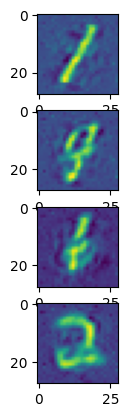

In [37]:
random_noise = torch.randn(64, 100).to(device)
print(random_noise)
fake_images = generator(random_noise, apply_sigmoid=True)
import matplotlib.pyplot as plt
print(fake_images[0].cpu().view(28,28).detach().numpy())
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,1)
axarr[0].imshow(fake_images[0].cpu().view(28,28).detach().numpy())
axarr[1].imshow(fake_images[1].cpu().view(28,28).detach().numpy())
axarr[2].imshow(fake_images[2].cpu().view(28,28).detach().numpy())
axarr[3].imshow(fake_images[3].cpu().view(28,28).detach().numpy())

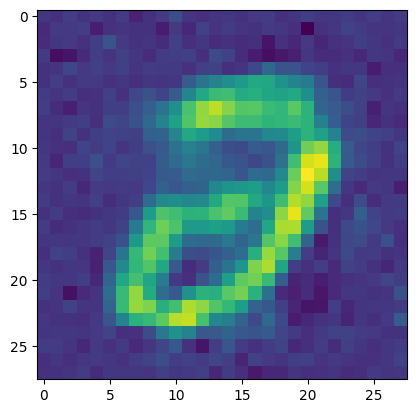

In [38]:
import matplotlib.pyplot as plt
plt.imshow(fake_images[10].cpu().view(28,28).detach().numpy())

In [39]:
discriminator(fake_images)

tensor([[ 0.1671],
        [-0.2244],
        [ 0.1313],
        [-0.2161],
        [ 0.0045],
        [ 0.1931],
        [-0.1624],
        [-0.0955],
        [-0.1379],
        [-0.2000],
        [-0.0551],
        [ 0.0062],
        [-0.1164],
        [-0.1238],
        [-0.1617],
        [-0.2932],
        [-0.0437],
        [-0.0037],
        [-0.3392],
        [-0.0594],
        [ 0.0015],
        [-0.0968],
        [-0.2756],
        [-0.0292],
        [-0.2707],
        [ 0.1169],
        [ 0.0616],
        [-0.3084],
        [-0.2941],
        [-0.0925],
        [-0.2824],
        [-0.1714],
        [ 0.0019],
        [-0.0581],
        [-0.0526],
        [-0.1377],
        [-0.1779],
        [-0.3025],
        [-0.0608],
        [-0.2976],
        [-0.1458],
        [-0.0643],
        [-0.0291],
        [-0.1981],
        [-0.2573],
        [-0.1034],
        [-0.1161],
        [-0.0289],
        [-0.3209],
        [-0.0724],
        [-0.2590],
        [-0.0106],
        [-0.

In [40]:
discriminator(real_images_batch)

tensor([[-0.1502],
        [ 0.1130],
        [-0.0476],
        [ 0.3136],
        [-0.2522],
        [-0.2538],
        [-0.1435],
        [-0.2092],
        [ 0.0350],
        [ 0.0048],
        [-0.0031],
        [-0.0306],
        [-0.1892],
        [-0.2973],
        [-0.2285],
        [ 0.1805],
        [ 0.0175],
        [-0.0282],
        [-0.1542],
        [-0.0623],
        [ 0.0159],
        [-0.0163],
        [ 0.0913],
        [-0.1808],
        [-0.3629],
        [-0.5091],
        [-0.0860],
        [ 0.0015],
        [-0.2790],
        [-0.2919],
        [-0.1210],
        [-0.1916],
        [ 0.1041],
        [-0.1773],
        [ 0.1921],
        [-0.1651],
        [-0.1616],
        [-0.3442],
        [ 0.0990],
        [-0.1055],
        [ 0.2554],
        [-0.1860],
        [-0.3544],
        [ 0.0641],
        [-0.1683],
        [-0.2415],
        [-0.1293],
        [-0.0189],
        [-0.1723],
        [-0.2893],
        [ 0.1969],
        [-0.1786],
        [-0.

In [ ]:
plt.imshow(real_images_batch[3].cpu().view(28,28).detach().numpy())

In [ ]:
fake_images